Project Workflow
1. Set up data folders in correct pattern
2.	Randomly split the images into training, validation, and test sets
3.	Image preprocessing and transformation
    - a. Images from each class will be transformed 
        - i. Flipped on horizontal axis
        - ii.	Flipped on vertical axis
        - iii. Rotated
        - iv. Horizontal shifts
        - v. Vertial shifts
        - vi.	Shear augmentation
    - b. Images will be downsampled to 250x250 pixel images
    - c. Pixel value normalization
4.	Design initial convolutional neural network architecture
5.	Train and validate
    a.	Repeat and modify CNN architecture to attempting to get above 90% accuracy.
6.	Test
7.	Report final results

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython.display import display, Image
from scipy.ndimage import imread
import os, shutil
import sys
import random
import time
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint  
from keras import applications
from keras.utils.np_utils import to_categorical
from keras.models import model_from_json
import random
from glob import glob
from sklearn.metrics import confusion_matrix
import itertools
#if K.image_data_format() == 'channels_first':
#    input_shape = (3, img_width, img_height)
#else:
#    input_shape = (img_width, img_height, 3)

Using TensorFlow backend.


### 1. Set up data folders

In [39]:
# Create a data folder
os.mkdir('data')
os.mkdir('data/train')
os.mkdir('data/valid')
os.mkdir('data/test')

In [40]:
# Remove windows thumbnail files
for folder in os.listdir('FIDS30'):
    for img in os.listdir('FIDS30/'+folder):
        if 'Thumbs.db' == img:
            os.remove('FIDS30/'+folder+'/'+img)

### 2. Split into training/validation/test sets

In [41]:
# loop through all the image files
filenames = []
for folder in os.listdir('FIDS30'):
    os.mkdir('data/train/'+folder)
    os.mkdir('data/valid/'+folder)
    os.mkdir('data/test/'+folder)
    files = os.listdir('FIDS30/'+folder)
    # shuffle data prior to splitting into train/validation/test sets
    random.shuffle(files)
    # 60% used as training data
    train_ix = int(len(files)*0.6)
    # 20% used as validation set
    valid_ix = int(len(files)*0.8)
    # assign the file paths to training, validation, or test data folders
    train = files[:train_ix]
    valid = files[train_ix:valid_ix]
    test = files[valid_ix:]
    for i in train:
        shutil.copy('FIDS30/'+folder+'/'+i,'data/train/'+folder)
    for j in valid:
        shutil.copy('FIDS30/'+folder+'/'+j,'data/valid/'+folder)
    for k in test:
        shutil.copy('FIDS30/'+folder+'/'+k,'data/test/'+folder)

### 3. Image preprocessing and transformation

In [2]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            cval=255,
            fill_mode='constant')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in 
# subfolders of 'data/train', and will indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
                    'data/train', # this is the target directory
                    target_size=(250,250), # all images will be resized to 259x250
                    batch_size=batch_size,
                    class_mode='categorical') # need categorical since not using binary target

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
                        'data/valid',
                        target_size=(250,250),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 2009 images belonging to 34 classes.
Found 675 images belonging to 34 classes.


The cells below create examples of the image manipulation we will perform on the dataset. This way we can see how the augementation affects the images.

In [3]:
datagen_ex = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            cval=255,
            fill_mode='constant')

img = load_img('data/train/acerolas/5.jpg') # this is a PIL image
x = img_to_array(img) # this is a NumPy array (3, x, y)
x = x.reshape((1,) + x.shape) # this is a NumPy array shaped as a tensor (1, 3, x, y)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen_ex.flow(x, batch_size=1,
                          save_to_dir='preview', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

I chose to use the `fill_mode='constant'` because the using `'nearest'` introduced artifacts that would not occur in real life (smearing effects). By using the constant fill mode, a white background fills space left blank after the image augmentation. This prevents fake/artifial features from appearing in the data.

Next, we can create a model architecture and start training.

### 4. Design initial convolutional neural network architecture

In [3]:
# dimensions of our images.
img_width, img_height = 250, 250

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(34, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
__________

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [7]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("scratch_model.json", "w") as json_file:
    json_file.write(model_json)

In [5]:

# create a checkpointer to save model weights
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.03.hdf5', 
                               verbose=1, save_best_only=True)

# now fit the model using the fit_generator
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2009 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=675 // batch_size,
        callbacks=[checkpointer])
model.save_weights('first_try.h5') # always save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 187s - loss: 3.3922 - acc: 0.1195 - val_loss: 3.0581 - val_acc: 0.2068
Epoch 2/50
125/125 [==============================] - 185s - loss: 2.9741 - acc: 0.1719 - val_loss: 2.5312 - val_acc: 0.2807
Epoch 3/50
125/125 [==============================] - 184s - loss: 2.6326 - acc: 0.2165 - val_loss: 2.2138 - val_acc: 0.2822
Epoch 4/50
125/125 [==============================] - 184s - loss: 2.5017 - acc: 0.2304 - val_loss: 2.2245 - val_acc: 0.2822
Epoch 5/50
125/125 [==============================] - 183s - loss: 2.3337 - acc: 0.2684 - val_loss: 2.0103 - val_acc: 0.3627
Epoch 6/50
125/125 [==============================] - 184s - loss: 2.2811 - acc: 0.3061 - val_loss: 2.0362 - val_acc: 0.3080
Epoch 7/50
125/125 [==============================] - 184s - loss: 2.1746 - acc: 0.3247 - val_loss: 1.8969 - val_acc: 0.3763
Epoch 8/50
125/125 [==============================] - 183s - loss: 2.1513 - acc: 0.3228 - val_loss: 2.0056 - val_acc: 0.3187


125/125 [==============================] - 183s - loss: 2.1079 - acc: 0.4316 - val_loss: 2.6486 - val_acc: 0.3126
Epoch 32/50
125/125 [==============================] - 182s - loss: 2.1103 - acc: 0.4338 - val_loss: 1.5224 - val_acc: 0.5220
Epoch 33/50
125/125 [==============================] - 181s - loss: 2.0384 - acc: 0.4301 - val_loss: 1.7743 - val_acc: 0.5008
Epoch 34/50
125/125 [==============================] - 182s - loss: 2.1285 - acc: 0.4198 - val_loss: 2.3976 - val_acc: 0.5114
Epoch 35/50
125/125 [==============================] - 181s - loss: 2.2034 - acc: 0.4204 - val_loss: 2.6232 - val_acc: 0.4219
Epoch 36/50
125/125 [==============================] - 182s - loss: 2.1976 - acc: 0.3969 - val_loss: 1.5941 - val_acc: 0.4962
Epoch 37/50
125/125 [==============================] - 181s - loss: 2.2556 - acc: 0.3868 - val_loss: 1.6787 - val_acc: 0.4886
Epoch 38/50
125/125 [==============================] - 182s - loss: 2.1288 - acc: 0.4217 - val_loss: 1.6278 - val_acc: 0.5933
Epoc

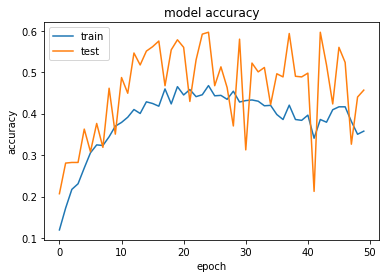

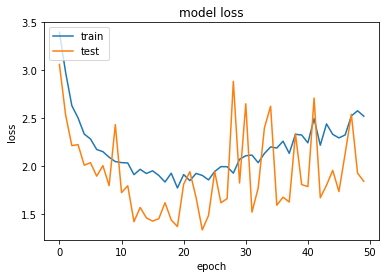

In [6]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# val_loss: 1.1858 - val_acc: 0.641 trial 1
# val_loss: 1.2730 - val_acc: 0.6464 trial 2
# val_loss: 1.3379 - val_acc: 0.5918 trial 3

The accuracy platueas after about 15-20 epochs, and the loss plateuas after about 12-15 epochs.

Next, let's try using class weights becuase the class sizes are unbalanced.

In [3]:
# create a dict to hold the class weights
class_weight= dict()
# loop through the folders containing the images, use the folder name as the key
for folder in os.listdir('data/train'):
    class_weight[folder] = len(os.listdir('data/train/'+folder))
# normalize the class weight relative to the class with the most examples
max_class = max(class_weight.values())
for key in class_weight.keys():
    class_weight[key] = max_class/class_weight[key]
# encode the dictionary keys as numeric labels
class_weights = dict()
for i in range(0,34): # classes are 0-indexed
    class_weights[i] = class_weight[sorted(class_weight.keys())[i]]

Use the same model architecture using the class weights parameter.

In [4]:
# dimensions of our images.
img_width, img_height = 250, 250

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model2.add(Dense(64))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(34, activation='softmax'))

print(model2.summary())

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
__________

In [5]:
# now run the model with class weights
# create a checkpointer to save model weights
checkpointer = ModelCheckpoint(filepath='saved_models/class-weights-weights-improvement03-{epoch:02d}-{val_acc:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

# now fit the model using the fit_generator
history = model2.fit_generator(
        train_generator,
        steps_per_epoch=2009 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=675 // batch_size,
        class_weight=class_weights,
        callbacks=[checkpointer])
model2.save_weights('saved_models/first_try_with_class_weights.h5') # always save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 187s - loss: 14.8306 - acc: 0.0545 - val_loss: 3.5166 - val_acc: 0.0551
Epoch 2/50
125/125 [==============================] - 190s - loss: 14.3860 - acc: 0.0635 - val_loss: 3.4807 - val_acc: 0.1123
Epoch 3/50
125/125 [==============================] - 189s - loss: 14.1953 - acc: 0.0825 - val_loss: 3.1898 - val_acc: 0.1639
Epoch 4/50
125/125 [==============================] - 186s - loss: 13.4874 - acc: 0.1205 - val_loss: 2.4331 - val_acc: 0.2519
Epoch 5/50
125/125 [==============================] - 187s - loss: 12.6110 - acc: 0.1739 - val_loss: 2.2023 - val_acc: 0.2656
Epoch 6/50
125/125 [==============================] - 189s - loss: 11.6882 - acc: 0.2193 - val_loss: 2.0604 - val_acc: 0.3080
Epoch 7/50
125/125 [==============================] - 191s - loss: 11.5331 - acc: 0.2489 - val_loss: 1.9253 - val_acc: 0.4006
Epoch 8/50
125/125 [==============================] - 189s - loss: 11.0812 - acc: 0.2706 - val_loss: 1.8013 - val_acc:

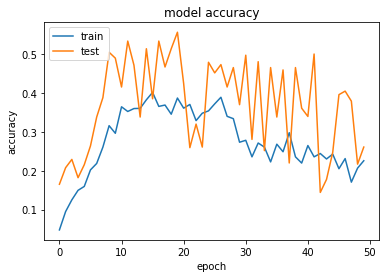

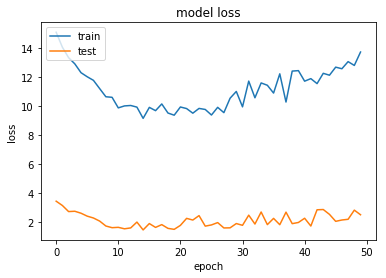

In [7]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# val_loss: 1.4879 - val_acc: 0.5144 trial 2
# val_loss: 1.3866 - val_acc: 0.5660 trial 3

Using class weights actually brought the accuracy down compared to the model without the class weights. Next, I will use transfer learning with the VGG16 CNN architecture. First, need to make dictionaries holding the file locations of each image. These will be fed to the VGG16 convolution layer which serves as a feature extractor.

In [6]:
# create a dict to hold the number of examples of each class in the train and valid data
nb_train_class= dict()
# loop through the folders containing the images, use the folder name as the key
for folder in os.listdir('data/train'):
    nb_train_class[folder] = len(os.listdir('data/train/'+folder))
nb_valid_class = dict()
for folder in os.listdir('data/valid'):
    nb_valid_class[folder] = len(os.listdir('data/valid/'+folder))
nb_test_class = dict()
for folder in os.listdir('data/test'):
    nb_test_class[folder] = len(os.listdir('data/test/'+folder))
print(sum(nb_train_class.values()))
print(sum(nb_valid_class.values()))
print(sum(nb_test_class.values()))

2009
675
689


In [4]:
# use transfer learning
# from keras import applications

# dimensions of our images
img_width, img_height = 250, 250

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/valid'
nb_train_samples = 2009
nb_validation_samples = 675
epochs = 50
batch_size = 16

def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means the generator will only yield data, no class labels
        shuffle=False) # our data will be in order
    
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    print(bottleneck_features_train.shape, 'train features')
    # save the output as a numpy array
    np.save(open('bottleneck_features_train.npy', 'wb'),
           bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    print(bottleneck_features_validation.shape, 'valid features')
    np.save(open('bottleneck_features_validation.npy', 'wb'),
           bottleneck_features_validation)



save_bottleneck_features()

Found 2009 images belonging to 34 classes.
(2000, 7, 7, 512) train features
Found 675 images belonging to 34 classes.
(672, 7, 7, 512) valid features


In [5]:

def train_top_model(nb_train_class, nb_valid_class):
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    print(train_data.shape, 'train data')
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array(
        [0] * nb_train_class['acerolas'] + [1] * nb_train_class['apples'] +
        [2] * nb_train_class['apricots'] + [3] * nb_train_class['avocados'] +
        [4] * nb_train_class['bananas'] + [5] * nb_train_class['blackberries'] +
        [6] * nb_train_class['blueberries'] + [7] * nb_train_class['cantaloupes'] +
        [8] * nb_train_class['cherries'] + [9] * nb_train_class['coconuts'] + 
        [10] * nb_train_class['figs'] + [11] * nb_train_class['grapefruits'] +
        [12] * nb_train_class['grapes'] + [13] * nb_train_class['guava'] +
        [14] * nb_train_class['honneydew_melon'] + [15] * nb_train_class['kiwifruit'] +
        [16] * nb_train_class['lemons'] + [17] * nb_train_class['limes'] + 
        [18] * nb_train_class['mangos'] + [19] * nb_train_class['nectarine'] +
        [20] * nb_train_class['olives'] + [21] * nb_train_class['onion'] +
        [22] * nb_train_class['orange'] + [23] * nb_train_class['passionfruit'] +
        [24] * nb_train_class['peaches'] + [25] * nb_train_class['pears'] +
        [26] * nb_train_class['pineapples'] + [27] * nb_train_class['plums'] +
        [28] * nb_train_class['pomegranates'] + [29] * nb_train_class['potato'] +
        [30] * nb_train_class['raspberries'] + [31] * nb_train_class['strawberries'] +
        [32] * nb_train_class['tomatoes'] + [33] * (nb_train_class['watermelon']-9))
    train_labels = to_categorical(train_labels, num_classes=34)
    print(train_labels.shape, 'train labels')

    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    print(validation_data.shape, 'valid data')
    validation_labels = np.array(
        [0] * nb_valid_class['acerolas'] + [1] * nb_valid_class['apples'] +
        [2] * nb_valid_class['apricots'] + [3] * nb_valid_class['avocados'] +
        [4] * nb_valid_class['bananas'] + [5] * nb_valid_class['blackberries'] +
        [6] * nb_valid_class['blueberries'] + [7] * nb_valid_class['cantaloupes'] +
        [8] * nb_valid_class['cherries'] + [9] * nb_valid_class['coconuts'] + 
        [10] * nb_valid_class['figs'] + [11] * nb_valid_class['grapefruits'] +
        [12] * nb_valid_class['grapes'] + [13] * nb_valid_class['guava'] +
        [14] * nb_valid_class['honneydew_melon'] + [15] * nb_valid_class['kiwifruit'] +
        [16] * nb_valid_class['lemons'] + [17] * nb_valid_class['limes'] + 
        [18] * nb_valid_class['mangos'] + [19] * nb_valid_class['nectarine'] +
        [20] * nb_valid_class['olives'] + [21] * nb_valid_class['onion'] +
        [22] * nb_valid_class['orange'] + [23] * nb_valid_class['passionfruit'] +
        [24] * nb_valid_class['peaches'] + [25] * nb_valid_class['pears'] +
        [26] * nb_valid_class['pineapples'] + [27] * nb_valid_class['plums'] +
        [28] * nb_valid_class['pomegranates'] + [29] * nb_valid_class['potato'] +
        [30] * nb_valid_class['raspberries'] + [31] * nb_valid_class['strawberries'] +
        [32] * nb_valid_class['tomatoes'] + [33] * (nb_valid_class['watermelon']-3))
    validation_labels = to_categorical(validation_labels, num_classes=34)
    np.save(open('validation_labels.npy', 'wb'),
           validation_labels)
    print(validation_labels.shape, 'valid labels')

    model3 = Sequential()
    model3.add(Flatten(input_shape=train_data.shape[1:]))
    model3.add(Dense(256, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(34, activation='softmax'))

    model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    # create a checkpointer to save model weights
    checkpointer = ModelCheckpoint(filepath='saved_models/tflearning-weights-improvement03-{epoch:02d}-{val_acc:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

    history = model3.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
                callbacks=[checkpointer])
    model3.save_weights('bottleneck_fc_model.h5')
    return history

history3 = train_top_model(nb_train_class, nb_valid_class)

(2000, 7, 7, 512) train data
(2000, 34) train labels
(672, 7, 7, 512) valid data
(672, 34) valid labels
Train on 2000 samples, validate on 672 samples
Epoch 1/50
2000/2000 [==============================] - 12s - loss: 3.6011 - acc: 0.2645 - val_loss: 1.8264 - val_acc: 0.5015
Epoch 2/50
2000/2000 [==============================] - 13s - loss: 1.9213 - acc: 0.4675 - val_loss: 1.5030 - val_acc: 0.5729
Epoch 3/50
2000/2000 [==============================] - 13s - loss: 1.5772 - acc: 0.5505 - val_loss: 1.3575 - val_acc: 0.6384
Epoch 4/50
2000/2000 [==============================] - 15s - loss: 1.3875 - acc: 0.6160 - val_loss: 1.0276 - val_acc: 0.7321
Epoch 5/50
2000/2000 [==============================] - 13s - loss: 1.2339 - acc: 0.6410 - val_loss: 1.0065 - val_acc: 0.7336
Epoch 6/50
2000/2000 [==============================] - 13s - loss: 1.1124 - acc: 0.6885 - val_loss: 1.0199 - val_acc: 0.7292
Epoch 7/50
2000/2000 [==============================] - 14s - loss: 0.9968 - acc: 0.7105 - va

In [6]:
def acc_loss_curve(model_history):
    # summarize history for accuracy
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
acc_loss_curve(history3)
# val_loss: 0.7571 - val_acc: 0.8244
# val_loss: 0.7994 - val_acc: 0.8051 trial 3

NameError: name 'history3' is not defined

Using the bottleneck features from the VGG16 network produced validation accuracies in the low 80% range. It looks like there is some over fitting going on after about 12 epochs. Now we can use the same strategy, but with class weights during training.

In [12]:
# dimensions of our images
img_width, img_height = 250, 250

train_data_dir = 'data/train'
validation_data_dir = 'data/valid'
nb_train_samples = 2009
nb_validation_samples = 675
epochs = 50
batch_size = 16
top_model_weights_path = 'bottleneck_fc_model_cw.h5'
def train_top_model(nb_train_class, nb_valid_class):
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    print(train_data.shape, 'train data')
    # the features were saved in order, so recreating the labels is easy
    train_labels = np.array(
        [0] * nb_train_class['acerolas'] + [1] * nb_train_class['apples'] +
        [2] * nb_train_class['apricots'] + [3] * nb_train_class['avocados'] +
        [4] * nb_train_class['bananas'] + [5] * nb_train_class['blackberries'] +
        [6] * nb_train_class['blueberries'] + [7] * nb_train_class['cantaloupes'] +
        [8] * nb_train_class['cherries'] + [9] * nb_train_class['coconuts'] + 
        [10] * nb_train_class['figs'] + [11] * nb_train_class['grapefruits'] +
        [12] * nb_train_class['grapes'] + [13] * nb_train_class['guava'] +
        [14] * nb_train_class['honneydew_melon'] + [15] * nb_train_class['kiwifruit'] +
        [16] * nb_train_class['lemons'] + [17] * nb_train_class['limes'] + 
        [18] * nb_train_class['mangos'] + [19] * nb_train_class['nectarine'] +
        [20] * nb_train_class['olives'] + [21] * nb_train_class['onion'] +
        [22] * nb_train_class['orange'] + [23] * nb_train_class['passionfruit'] +
        [24] * nb_train_class['peaches'] + [25] * nb_train_class['pears'] +
        [26] * nb_train_class['pineapples'] + [27] * nb_train_class['plums'] +
        [28] * nb_train_class['pomegranates'] + [29] * nb_train_class['potato'] +
        [30] * nb_train_class['raspberries'] + [31] * nb_train_class['strawberries'] +
        [32] * nb_train_class['tomatoes'] + [33] * (nb_train_class['watermelon']-9))
    train_labels = to_categorical(train_labels, num_classes=34)
    print(train_labels.shape, 'train labels')

    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    print(validation_data.shape, 'valid data')
    validation_labels = np.array(
        [0] * nb_valid_class['acerolas'] + [1] * nb_valid_class['apples'] +
        [2] * nb_valid_class['apricots'] + [3] * nb_valid_class['avocados'] +
        [4] * nb_valid_class['bananas'] + [5] * nb_valid_class['blackberries'] +
        [6] * nb_valid_class['blueberries'] + [7] * nb_valid_class['cantaloupes'] +
        [8] * nb_valid_class['cherries'] + [9] * nb_valid_class['coconuts'] + 
        [10] * nb_valid_class['figs'] + [11] * nb_valid_class['grapefruits'] +
        [12] * nb_valid_class['grapes'] + [13] * nb_valid_class['guava'] +
        [14] * nb_valid_class['honneydew_melon'] + [15] * nb_valid_class['kiwifruit'] +
        [16] * nb_valid_class['lemons'] + [17] * nb_valid_class['limes'] + 
        [18] * nb_valid_class['mangos'] + [19] * nb_valid_class['nectarine'] +
        [20] * nb_valid_class['olives'] + [21] * nb_valid_class['onion'] +
        [22] * nb_valid_class['orange'] + [23] * nb_valid_class['passionfruit'] +
        [24] * nb_valid_class['peaches'] + [25] * nb_valid_class['pears'] +
        [26] * nb_valid_class['pineapples'] + [27] * nb_valid_class['plums'] +
        [28] * nb_valid_class['pomegranates'] + [29] * nb_valid_class['potato'] +
        [30] * nb_valid_class['raspberries'] + [31] * nb_valid_class['strawberries'] +
        [32] * nb_valid_class['tomatoes'] + [33] * (nb_valid_class['watermelon']-3))
    validation_labels = to_categorical(validation_labels, num_classes=34)
    print(validation_labels.shape, 'valid labels')

    model4 = Sequential()
    model4.add(Flatten(input_shape=train_data.shape[1:]))
    model4.add(Dense(256, activation='relu'))
    model4.add(Dropout(0.5))
    model4.add(Dense(34, activation='softmax'))

    model4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    # create a checkpointer to save model weights
    checkpointer = ModelCheckpoint(filepath='saved_models/tflearningwclassweights02-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

    history = model4.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
            class_weight=class_weights,
              validation_data=(validation_data, validation_labels),
            callbacks=[checkpointer])
    model4.save_weights('saved_models/bottleneck_fc_model_cw.h5')
    from keras.models import model_from_json
    # serialize model to JSON
    model_json = model4.to_json()
    with open("bestmodel.json", "w") as json_file:
        json_file.write(model_json)
    return history

history4 = train_top_model(nb_train_class, nb_valid_class)

(2000, 7, 7, 512) train data
(2000, 34) train labels
(672, 7, 7, 512) valid data
(672, 34) valid labels
Train on 2000 samples, validate on 672 samples
Epoch 1/50
2000/2000 [==============================] - 12s - loss: 24.0687 - acc: 0.1340 - val_loss: 2.6632 - val_acc: 0.2753
Epoch 2/50
2000/2000 [==============================] - 13s - loss: 12.4750 - acc: 0.2755 - val_loss: 2.0578 - val_acc: 0.4137
Epoch 3/50
2000/2000 [==============================] - 13s - loss: 10.5643 - acc: 0.3870 - val_loss: 1.4807 - val_acc: 0.5818
Epoch 4/50
2000/2000 [==============================] - 13s - loss: 9.9022 - acc: 0.4670 - val_loss: 1.2102 - val_acc: 0.6920
Epoch 5/50
2000/2000 [==============================] - 13s - loss: 8.2471 - acc: 0.5355 - val_loss: 1.2248 - val_acc: 0.6696
Epoch 6/50
2000/2000 [==============================] - 13s - loss: 7.2037 - acc: 0.5805 - val_loss: 1.1478 - val_acc: 0.7098
Epoch 7/50
2000/2000 [==============================] - 13s - loss: 6.3093 - acc: 0.6330 -

2000/2000 [==============================] - 13s - loss: 1.3958 - acc: 0.9130 - val_loss: 1.1185 - val_acc: 0.8393
Epoch 30/50
2000/2000 [==============================] - 11s - loss: 2.2872 - acc: 0.9105 - val_loss: 0.9549 - val_acc: 0.8542
Epoch 31/50
2000/2000 [==============================] - 11s - loss: 1.2856 - acc: 0.9140 - val_loss: 1.0522 - val_acc: 0.8452
Epoch 32/50
2000/2000 [==============================] - 11s - loss: 1.3297 - acc: 0.9230 - val_loss: 1.1326 - val_acc: 0.8438
Epoch 33/50
2000/2000 [==============================] - 11s - loss: 1.7174 - acc: 0.9215 - val_loss: 1.1902 - val_acc: 0.8304
Epoch 34/50
2000/2000 [==============================] - 11s - loss: 1.5543 - acc: 0.9215 - val_loss: 1.0645 - val_acc: 0.8423
Epoch 35/50
2000/2000 [==============================] - 11s - loss: 2.5319 - acc: 0.9105 - val_loss: 1.3706 - val_acc: 0.8274
Epoch 36/50
2000/2000 [==============================] - 11s - loss: 1.3320 - acc: 0.9255 - val_loss: 1.0959 - val_acc: 0.8

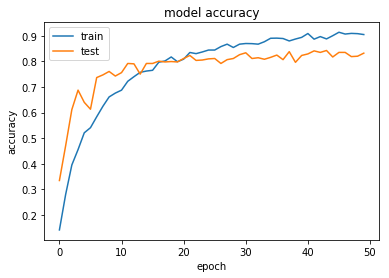

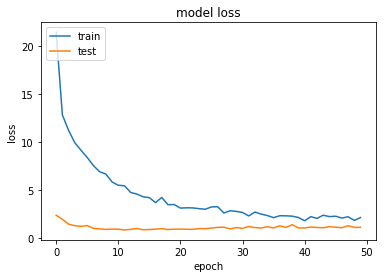

In [7]:
acc_loss_curve(history4)
# val_acc 0.7915
#val_loss: 0.8618 - val_acc: 0.8348
#val_loss: 0.8868 - val_acc: 0.7917

After running three trials of each CNN architecture, I selected the weights with the lowest loss on the validation data from the model using transfer learning with class weights. Below, I load a model with those weights and apply to the test data which has not been used during training.

In [2]:
json_file = open('bestmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/tflearningwclassweights02-weights-improvement-16-0.84.hdf5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Loaded model from disk


Modify the save_bottleneck_features function for use with the test data

In [4]:
def produce_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
    batch_size = 16
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        'data/test',
        target_size=(250, 250),
        batch_size=16,
        class_mode=None, # this means the generator will only yield data, no class labels
        shuffle=False) # our data will be in order
    
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    bottleneck_features_test = model.predict_generator(
        generator, 689 // batch_size)
    print(bottleneck_features_test.shape, 'test features')
    # save the output as a numpy array
    np.save(open('bottleneck_features_test.npy', 'wb'),
           bottleneck_features_test)
    return bottleneck_features_test


Create an array holding all the labels of the test data.

In [7]:
test_labels = np.array(
        [0] * nb_test_class['acerolas'] + [1] * nb_test_class['apples'] +
        [2] * nb_test_class['apricots'] + [3] * nb_test_class['avocados'] +
        [4] * nb_test_class['bananas'] + [5] * nb_test_class['blackberries'] +
        [6] * nb_test_class['blueberries'] + [7] * nb_test_class['cantaloupes'] +
        [8] * nb_test_class['cherries'] + [9] * nb_test_class['coconuts'] + 
        [10] * nb_test_class['figs'] + [11] * nb_test_class['grapefruits'] +
        [12] * nb_test_class['grapes'] + [13] * nb_test_class['guava'] +
        [14] * nb_test_class['honneydew_melon'] + [15] * nb_test_class['kiwifruit'] +
        [16] * nb_test_class['lemons'] + [17] * nb_test_class['limes'] + 
        [18] * nb_test_class['mangos'] + [19] * nb_test_class['nectarine'] +
        [20] * nb_test_class['olives'] + [21] * nb_test_class['onion'] +
        [22] * nb_test_class['orange'] + [23] * nb_test_class['passionfruit'] +
        [24] * nb_test_class['peaches'] + [25] * nb_test_class['pears'] +
        [26] * nb_test_class['pineapples'] + [27] * nb_test_class['plums'] +
        [28] * nb_test_class['pomegranates'] + [29] * nb_test_class['potato'] +
        [30] * nb_test_class['raspberries'] + [31] * nb_test_class['strawberries'] +
        [32] * nb_test_class['tomatoes'] + [33] * (nb_test_class['watermelon']-1))
test_labels = to_categorical(test_labels, num_classes=34)
np.save(open('test_labels.npy', 'wb'),
           test_labels)
print(test_labels.shape, 'test labels')

(688, 34) test labels


In [8]:
# create a numpy array of the bottleneck features that can be fed to the top layer model.
X = produce_bottleneck_features()

Found 689 images belonging to 34 classes.
(688, 7, 7, 512) test features


Finally, evaluate the model on the test data.

In [172]:
results = loaded_model.evaluate(X, test_labels)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1], results[1]*100))

640/688 [==========================>...] - ETA: 0s
acc: 80.67%


In [15]:
fruit_names = [item[11:-1] for item in sorted(glob("data/train/*/"))]
print(fruit_names)

['acerolas', 'apples', 'apricots', 'avocados', 'bananas', 'blackberries', 'blueberries', 'cantaloupes', 'cherries', 'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'honneydew_melon', 'kiwifruit', 'lemons', 'limes', 'mangos', 'nectarine', 'olives', 'onion', 'orange', 'passionfruit', 'peaches', 'pears', 'pineapples', 'plums', 'pomegranates', 'potato', 'raspberries', 'strawberries', 'tomatoes', 'watermelon']


Finally, we create a confusion matrix to evaluate the accuracy of specific classes in the data set.

Confusion matrix, without normalization
[[ 0  0  0 ...,  0  0  0]
 [ 0 73  0 ...,  0  0  0]
 [ 0  0  2 ...,  0  0  0]
 ..., 
 [ 0  0  0 ...,  5  0  0]
 [ 0  1  0 ...,  1  7  0]
 [ 0  0  0 ...,  0  0 41]]


c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Normalized confusion matrix
[[  nan   nan   nan ...,   nan   nan   nan]
 [ 0.    0.92  0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.22 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  1.    0.    0.  ]
 [ 0.    0.06  0.   ...,  0.06  0.44  0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.84]]


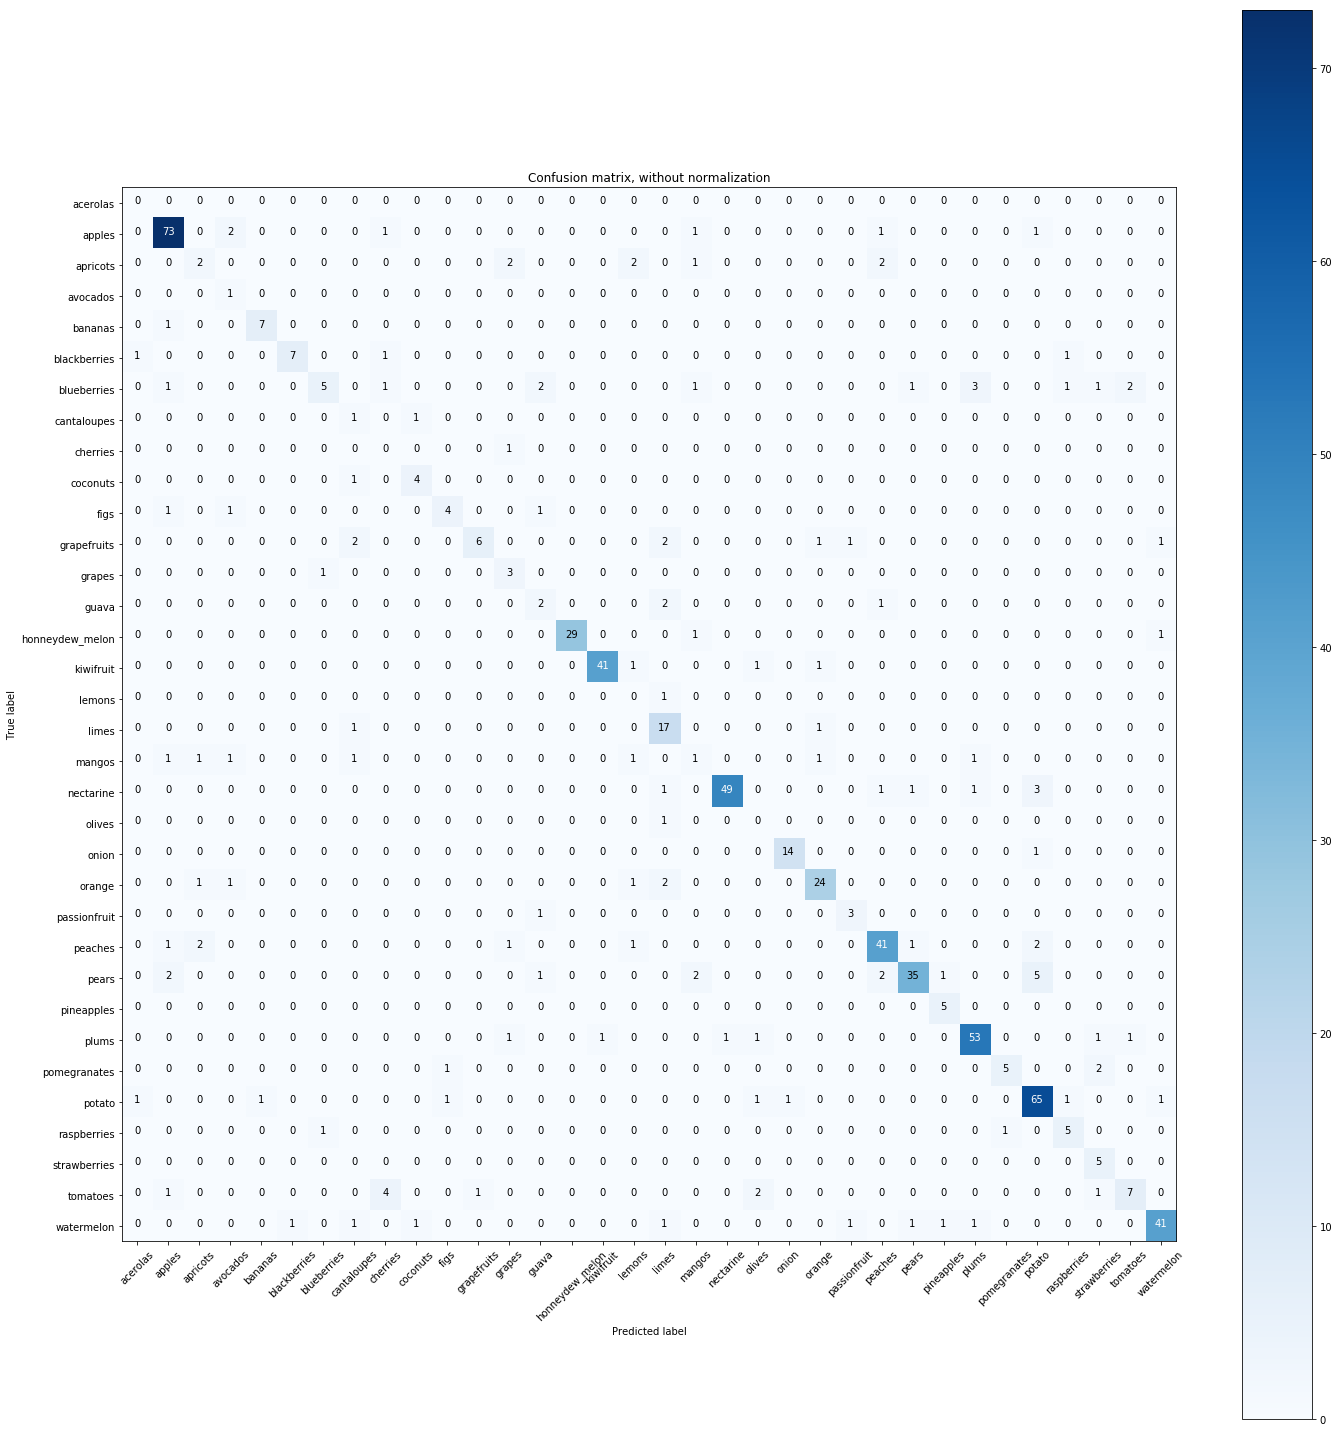

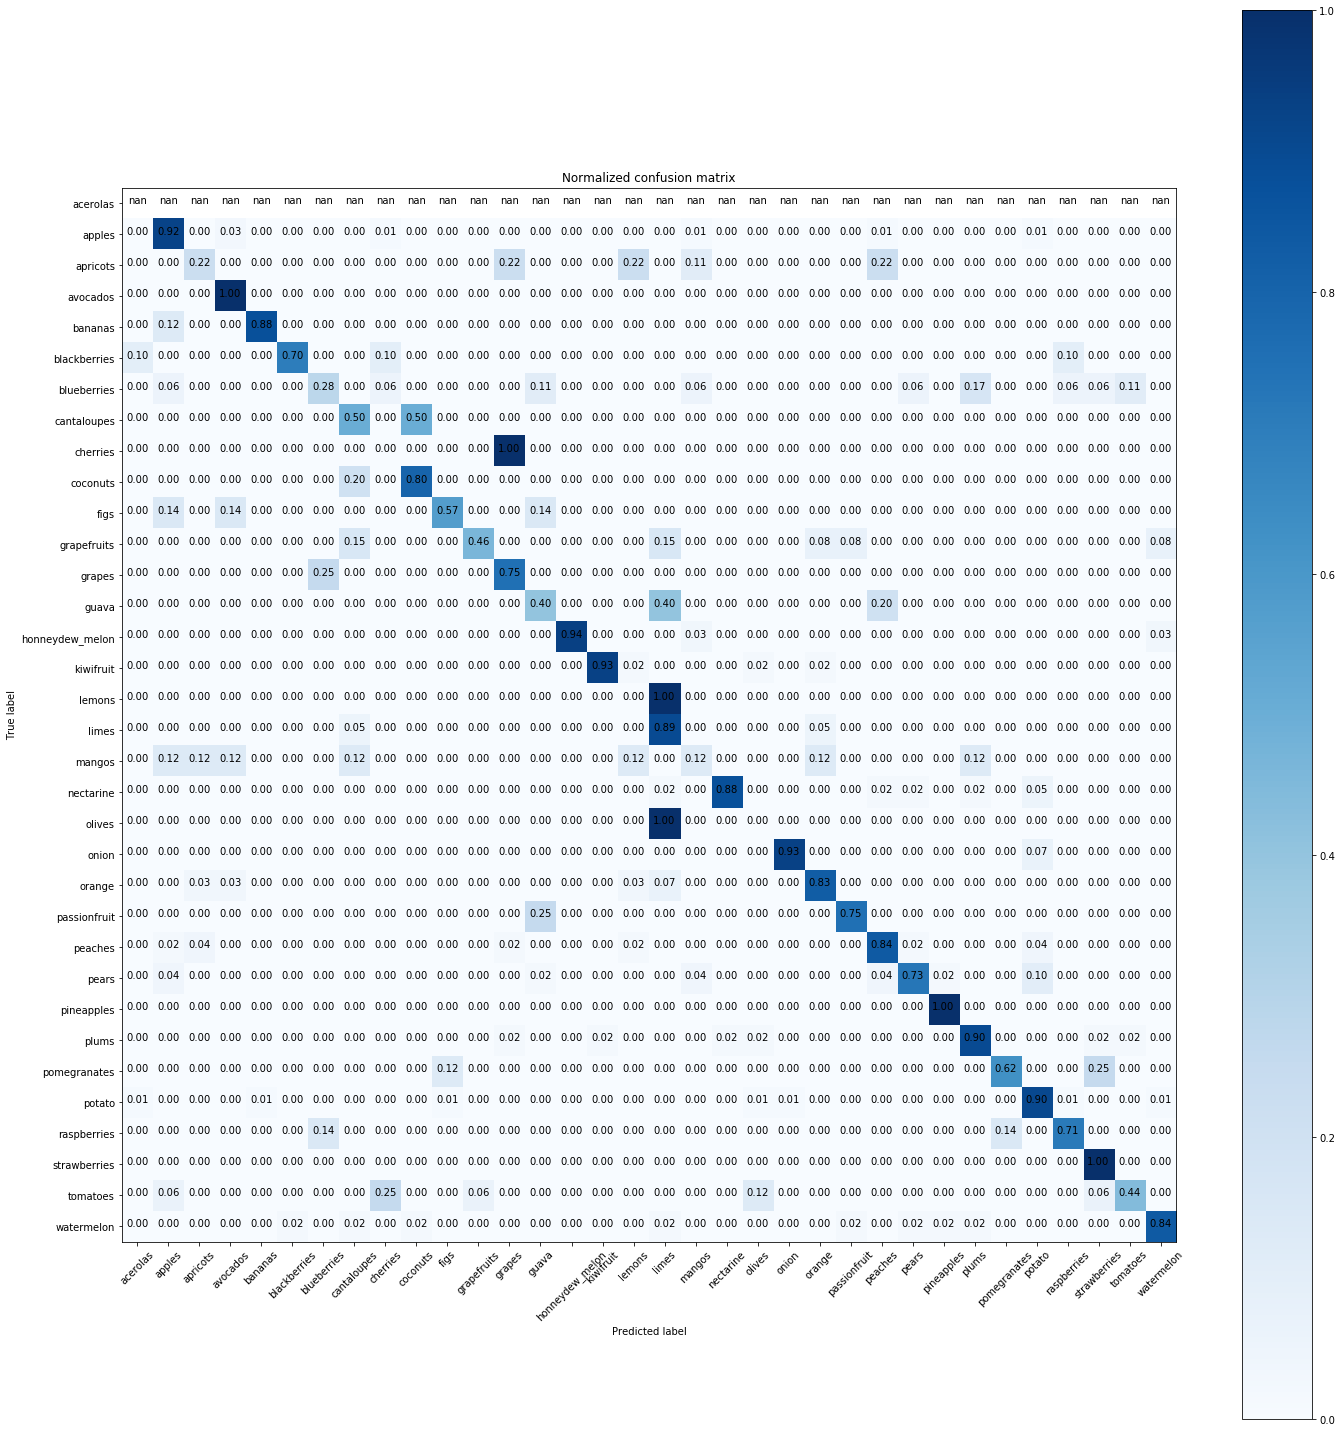

688

In [17]:
# confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix([np.argmax(x) for x in loaded_model.predict(X)], [np.argmax(x) for x in test_labels])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=fruit_names,
                      title='Confusion matrix, without normalization')
plt.savefig('cm.png')

# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=fruit_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('cmnorm.png')
plt.show()

#test_labels
#[np.argmax(x) for x in loaded_model.predict(X)]
np.sum(confusion_matrix([np.argmax(x) for x in loaded_model.predict(X)], [np.argmax(x) for x in test_labels]))

In [158]:
# just some code to quickly pull out the class accuracies and the names of each row
for i in range(cnf_matrix.shape[0]):
    print('{:.2f}'.format(cnf_matrix[i,i]/np.sum(cnf_matrix[:,i])*100))
for i in range(cnf_matrix.shape[0]):
    print('{}'.format(fruit_names[i]))

0.00
90.12
33.33
16.67
87.50
87.50
71.43
14.29
0.00
66.67
66.67
85.71
37.50
28.57
100.00
97.62
0.00
62.96
14.29
98.00
0.00
93.33
85.71
60.00
85.42
89.74
71.43
89.83
83.33
84.42
62.50
50.00
70.00
93.18
acerolas
apples
apricots
avocados
bananas
blackberries
blueberries
cantaloupes
cherries
coconuts
figs
grapefruits
grapes
guava
honneydew_melon
kiwifruit
lemons
limes
mangos
nectarine
olives
onion
orange
passionfruit
peaches
pears
pineapples
plums
pomegranates
potato
raspberries
strawberries
tomatoes
watermelon


In [214]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    print(image)
    img = image.load_img(img_path, target_size=(250, 250))
    # convert PIL.Image.Image type to 3D tensor with shape (250, 250, 3)
    x = image.img_to_array(img)
    # normalize the image
    x /= 255
    # convert 3D tensor to 4D tensor with shape (1, 250, 250, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [208]:
def top_produce_predictor(img_path):
    """Depends on the path to tensor function, having a loaded model, and the fruit
    names array being created"""
    from keras.applications.vgg16 import VGG16
    # convert image file to a 4D tensor with shape (1,250,250,3)
    # tensor has normed pixel values
    normed_array = path_to_tensor(img_path)
    # extract the bottleneck features
    extracted_features = VGG16(weights='imagenet', include_top=False).predict(normed_array)
    # make predictions on the features
    preds = loaded_model.predict(extracted_features)
    return fruit_names[np.argmax(preds)]

In [215]:
top_produce_predictor('data/test/honneydew_melon/honneydew_melon_013.jpg')

<module 'keras.preprocessing.image' from 'c:\\users\\john maxi\\anaconda3\\envs\\tensorflowenv\\lib\\site-packages\\keras\\preprocessing\\image.py'>


'honneydew_melon'

In [211]:
top_produce_predictor('data/test/nectarine/nectarine_078.jpg')

'nectarine'

In [16]:
# model 1
#first_try.h5
#weights.best.from_scratch.02.hdf5
#weights.best.from_scratch.03.hdf5
# model 2
#class-weights-weights-improvement-26-0.54.hdf5
#class-weights-weights-improvement02-14-0.51.hdf5
#class-weights-weights-improvement03-25-0.57.hdf5
# model 3
#tflearning-weights-improvement-10-0.81.hdf5
#tflearning-weights-improvement02-12-0.82.hdf5
#tflearning-weights-improvement03-12-0.81.hdf5
# model 4
#tflearningwclassweights-weights-improvement-09-0.79.hdf5
#tflearningwclassweights02-weights-improvement-18-0.83.hdf5
#tflearningwclassweights03-weights-improvement-16-0.84.hdf5
def load_a_model(model, weights):
    json_file = open(model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights)
    print("Loaded model from disk")
    return loaded_model

weights_list = ['first_try.h5']
for w in weights_list:
    # load the model
    curr_model = load_a_model('scratch_model.json', w)
    # compile the model
    curr_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # evaluate the model on validation data
    preds = curr_model.predict_generator(validation_generator, steps=675)
    print(preds.shape)
    for i in preds:
        np.put(preds,np.where(i),np.argmax(i))
    print(i)
    print(preds)
    #score = f1_score(validation_generator.classes,preds,average='weighted')

Loaded model from disk
(10605, 34)
[ 0.00734257  0.0550801   0.0239051   0.02283614  0.03092976  0.02933197
  0.02350995  0.02658211  0.02566814  0.02258073  0.02002076  0.02524665
  0.02918338  0.0263679   0.02916536  0.04755478  0.01972011  0.029465
  0.02802422  0.04417045  0.01815821  0.01325345  0.04677913  0.01881557
  0.04835045  0.03738371  0.03091703  0.02958899  0.02435     0.02331149
  0.0306966   0.03520932  0.03495983  0.04154112]
[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  3.15205692e-18   6.35384619e-02   3.87358568e-14 ...,   2.28588947e-17
    4.93588068e-16   1.33601790e-02]
 [  5.87087670e-05   2.32318535e-01   3.73203220e-04 ...,   3.10981792e-04
    3.24324385e-04   2.50949943e-03]
 ..., 
 [  8.67761279e-11   1.95161998e-03   3.61621866e-09 ...,   1.07064531e-10
    2.98521902e-10   2.06606364e-05]
 [  1.12556353e-26   2.09591331e-08   2.07932627e-22 ...,   2.01546754e-22
    1.39881901e-22   2

In [10]:
len(validation_generator.classes)

675